# Assignment 01: Python notebook for analysis

This notebook analyzes the netflix dataset and is used to answer various research and visualiztion questions. 




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

SEED = 0
rng = np.random.default_rng(SEED)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

DATA_DIR = Path("../data/netflix")
CSV_PATH = DATA_DIR / "netflix_titles.csv"

In [2]:
df = pd.read_csv(CSV_PATH)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
# Parse dates (coerce errors -> NaT)
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year

df[["title", "type", "date_added", "year_added"]].head(10)

,title,type,date_added,year_added
0,Dick Johnson Is Dead,Movie,2021-09-25,2021.0
1,Blood & Water,TV Show,2021-09-24,2021.0
2,Ganglands,TV Show,2021-09-24,2021.0
3,Jailbirds New Orleans,TV Show,2021-09-24,2021.0
4,Kota Factory,TV Show,2021-09-24,2021.0
5,Midnight Mass,TV Show,2021-09-24,2021.0
6,My Little Pony: A New Generation,Movie,2021-09-24,2021.0
7,Sankofa,Movie,2021-09-24,2021.0
8,The Great British Baking Show,TV Show,2021-09-24,2021.0
9,The Starling,Movie,2021-09-24,2021.0


In [4]:
# Q2) Titles added per year (ignoring missing dates)
added_per_year = df.dropna(subset=["year_added"]).groupby("year_added").size()
added_per_year.tail()

year_added
2017.0    1164
2018.0    1625
2019.0    1999
2020.0    1878
2021.0    1498
dtype: int64

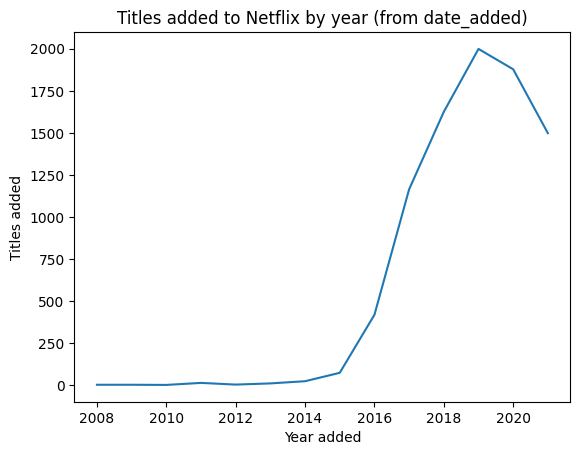

In [5]:
plt.figure()
plt.plot(added_per_year.index, added_per_year.values)
plt.xlabel("Year added")
plt.ylabel("Titles added")
plt.title("Titles added to Netflix by year (from date_added)")
plt.show()


In [6]:
# Make sure date_added is datetime and create year_added
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year

df[["title", "date_added", "year_added", "country"]]


,title,date_added,year_added,country
0,Dick Johnson Is Dead,2021-09-25,2021.0,United States
1,Blood & Water,2021-09-24,2021.0,South Africa
2,Ganglands,2021-09-24,2021.0,NaN
3,Jailbirds New Orleans,2021-09-24,2021.0,NaN
4,Kota Factory,2021-09-24,2021.0,India
...,...,...,...,...
8802,Zodiac,2019-11-20,2019.0,United States
8803,Zombie Dumb,2019-07-01,2019.0,NaN
8804,Zombieland,2019-11-01,2019.0,United States
8805,Zoom,2020-01-11,2020.0,United States


In [7]:
# Q3) Top countries
# country field can contain multiple countries separated by commas.
countries = (
    df["country"]
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
)
top_countries = countries.value_counts().head(10)
top_countries

country
United States     3690
India             1046
United Kingdom     806
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico             169
Name: count, dtype: int64

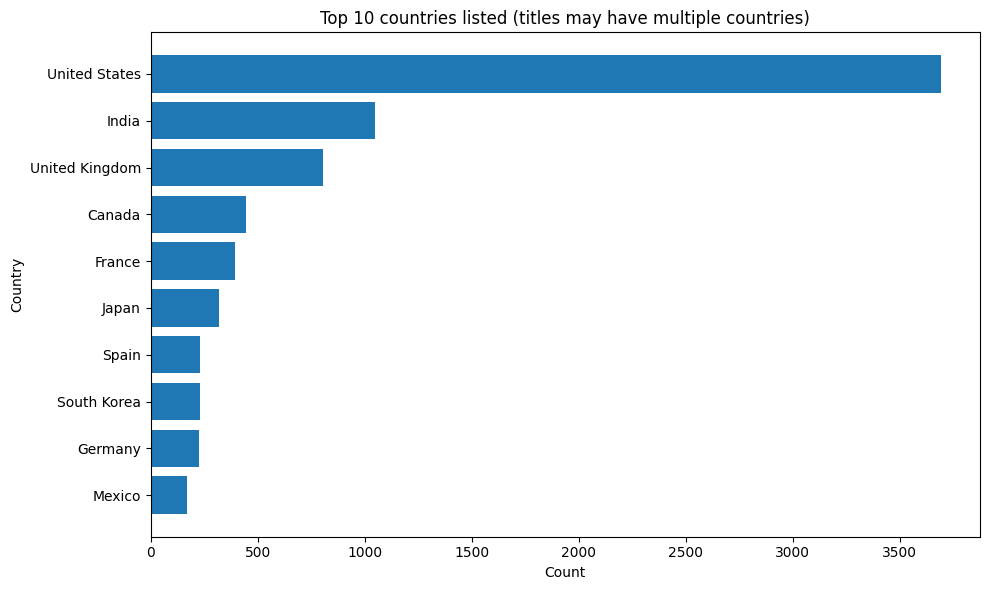

In [8]:
plt.figure(figsize=(10,6))
plt.barh(top_countries.index[::-1], top_countries.values[::-1])
plt.xlabel("Count")
plt.ylabel("Country")
plt.title("Top 10 countries listed (titles may have multiple countries)")
plt.tight_layout()
plt.show()


In [9]:
country_year = (
    df.dropna(subset=["year_added", "country"])
      .assign(country=df["country"].str.split(","))
      .explode("country")
)

country_year["country"] = country_year["country"].str.strip()

country_year_counts = (
    country_year.groupby(["year_added", "country"])
                .size()
                .reset_index(name="count")
)

country_year_counts.head(10)



,year_added,country,count
0,2008.0,United States,2
1,2009.0,Denmark,1
2,2009.0,United States,1
3,2010.0,United States,1
4,2011.0,France,2
5,2011.0,Mexico,1
6,2011.0,Spain,1
7,2011.0,United Kingdom,1
8,2011.0,United States,12
9,2012.0,Mexico,1


In [10]:
top10 = top_countries.index.tolist()

country_year_top10 = country_year_counts[country_year_counts["country"].isin(top10)]
country_year_top10.head(10)


,year_added,country,count
0,2008.0,United States,2
2,2009.0,United States,1
3,2010.0,United States,1
4,2011.0,France,2
5,2011.0,Mexico,1
6,2011.0,Spain,1
7,2011.0,United Kingdom,1
8,2011.0,United States,12
9,2012.0,Mexico,1
10,2012.0,United States,3


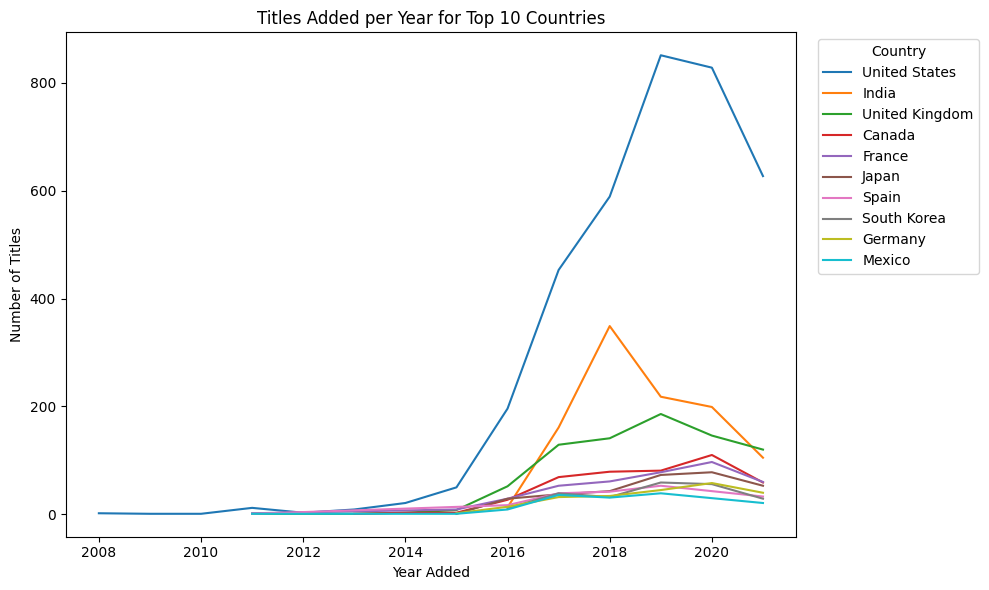

In [11]:
plt.figure(figsize=(10,6))

for c in top10:
    subset = country_year_top10[country_year_top10["country"] == c].sort_values("year_added")
    plt.plot(subset["year_added"], subset["count"], label=c)

plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.title("Titles Added per Year for Top 10 Countries")
plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
